In [73]:
# imports

import pickle
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
import random
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset, random_split
from torch.autograd import Variable
import torchvision.utils
import time
import copy
from torch.optim import lr_scheduler
import os
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F




## hyper-parameters

In [74]:
random_seed = 42

## Preprocessing and Loading dataset

In [75]:
with open('dataset.pkl', 'rb') as f:
    data = pickle.load(f)

df_uwb_data = data['data_CIR']
df_uwb = data['data_t']

In [76]:
## Train & valdiation & Test split
X_train, X_test, y_train, y_test = train_test_split(df_uwb_data.values, df_uwb['NLOS'].values, test_size=0.1, random_state=random_seed, stratify=df_uwb['NLOS'].values)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=random_seed, stratify=y_train)

print('X_train_shape {}, y_train_shape {} : '.format(X_train.shape, y_train.shape))
# print('X_val_shape {}, y_val_shape {} : '.format(X_val.shape, y_val.shape))
print('X_test_shape {}, y_test_shape {} : '.format(X_test.shape, y_test.shape))

print("Train NLOS 0 count :", len(y_train[y_train==0])) 
print("Train NLOS 1 count :", len(y_train[y_train==1])) 
# print("Validation NLOS 0 count :", len(y_val[y_val==0])) 
# print("Validation NLOS 1 count :", len(y_val[y_val==1])) 
print("Test NLOS 0 count :", len(y_test[y_test==0])) 
print("Test NLOS 0 count :", len(y_test[y_test==1]))


X_train_shape (37800, 1016), y_train_shape (37800,) : 
X_test_shape (4200, 1016), y_test_shape (4200,) : 
Train NLOS 0 count : 18900
Train NLOS 1 count : 18900
Test NLOS 0 count : 2100
Test NLOS 0 count : 2100


## Amplitude to dB Scale

In [77]:
## amplitude to dB
X_train_dB = librosa.amplitude_to_db(X_train)
X_test_dB = librosa.amplitude_to_db(X_test)

# plt.figure()
# plt.plot(X_train[0])
# plt.figure()
# plt.plot(X_train[1])
# plt.figure()
# plt.plot(X_train_dB[0])

## nomalization
# scaler = preprocessing.MinMaxScaler().fit(X_train)
# X_train_SC = scaler.transform(X_train)
# X_test_SC = scaler.transform(X_test)

# plt.figure()
# plt.plot(X_train_SC[0])
# plt.figure()
# plt.plot(X_train_SC[1])


In [78]:
idx_los = np.where(y_train==0)[0]
idx_nlos = np.where(y_train==1)[0]
print(idx_los)
print(idx_nlos)
X_train_vec = X_train.reshape(-1,1,1016)
X_test_vec = X_test.reshape(-1,1,1016)
# X_test_vec.shape




[    7     8     9 ... 37797 37798 37799]
[    0     1     2 ... 37787 37791 37796]


In [79]:
class SiameseNetworkDataset():
    
    def __init__(self,training_data=None,training_dir=None, setSize=None, transform=None):
        # used to prepare the labels and images path
        self.training_data = training_data
        # self.training_df.columns =["image1","image2","label"]
        self.training_dir = training_dir    
        self.transform = transform
        self.setSize = setSize

    def __len__(self):
        return self.setSize
    def __getitem__(self,idx):
        # get class index
        idx_los = np.where(self.training_dir==0)[0]
        idx_nlos = np.where(self.training_dir==1)[0]
        # select label
        if idx % 2 == 0:
            category = random.randint(0,1)
            if category == 0:
                img1_idx = random.choice(idx_los) # LOS
                img2_idx = random.choice(idx_los)
                
            else:
                img1_idx = random.choice(idx_nlos) # NLOS
                img2_idx = random.choice(idx_nlos)
            img1 = self.training_data[img1_idx] 
            img2 = self.training_data[img2_idx]
            label = 1.0

        else:
            category2 = random.randint(0,1)
            if category2 == 0:
                img1_idx = random.choice(idx_los)
                img2_idx = random.choice(idx_nlos)
            else:
                img1_idx = random.choice(idx_nlos)
                img2_idx = random.choice(idx_los)
            img1 = self.training_data[img1_idx] 
            img2 = self.training_data[img2_idx]
            label = 0.0

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.from_numpy(np.array([label], dtype=np.float32))



In [80]:

# creates n-way one shot learning evaluation
class SiameseEvalSet(Dataset):
    def __init__(self, test_data, test_dir, setSize, numWay, transform=None):
        self.test_data = test_data
        # self.test_df.columns =["image1","image2","label"]
        self.test_dir = test_dir    
        self.transform = transform
        self.setSize = setSize
    def __len__(self):
        return self.setSize
    def __getitem__(self, idx):
        idx_los = np.where(self.test_dir==0)[0]
        idx_nlos = np.where(self.test_dir==1)[0]
        # find one main image, 0 is LOS , 1 is NLOS
        category = random.randint(0,1)
        if category == 0: # if selected label is LOS
            mainimg_idx = random.choice(idx_los) # LOS
        else:
            mainimg_idx = random.choice(idx_nlos) 

        mainimg = test_data[mainimg_idx]
        if self.transfrom:
            mainImg = self.transfrom(mainimg)

        # find n numbers of distinct images, 1 in the same set as the main
        testSet = []
        label = np.random.randint(self.numWay) # 0 or 1
        for i in range(self.numWay):
            if i == label:
                if category == 0:
                    test_idx = random_choice(idx_los)
                else:
                    test_idx = random.choice(idx_nlos)
            else:
                if category == 0:
                    test_idx = random.choice(idx_nlos)
                else:
                    test_idx = random.choice(idx_los)

            testImg = test_data[test_idx]
            if self.transform:
                testImg = self.transform(testImg)
            testSet.append(testImg)
            # plt.imshow()
            return mainImg, testSet, torch.from_numpy(np.array([label], dtype = int))
            

In [81]:
# choose a training dataset size and further divide it into train and validation set 80:20
dataSize = 100000 # self-defined dataset size
TRAIN_PCT = 0.8 # percentage of entire dataset for training
train_size = int(dataSize * TRAIN_PCT)
val_size = dataSize - train_size
print(train_size,val_size)
transformations = transforms.Compose(
    [transforms.ToTensor()]) 

CIRdataset = SiameseNetworkDataset(training_data = X_train_vec, training_dir=y_train, setSize=dataSize, transform=transformations)
train_set, val_set = random_split(CIRdataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, num_workers=2, shuffle=True)

80000 20000


tensor([[0.]])


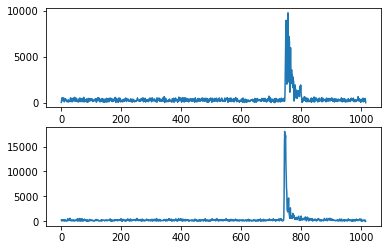

In [82]:
# Viewing the sample of images and to check whetehr its loading properly
dataloader = DataLoader(CIRdataset,
                        shuffle=True,
                        batch_size=1)
dataiter = iter(dataloader)

image1, image2, label = dataiter.next()

print(label)
plt.figure()
plt.subplot(211)
plt.plot(image1.squeeze())
plt.subplot(212)
plt.plot(image2.squeeze())

# concatenated = torch.cat((example_batch[0],example_batch[1]),0)
# imshow(torchvision.utils.make_grid(concatenated))
# print(example_batch[2].numpy())

In [83]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Conv2d(input_channels, output_channels, kernel_size)
        self.conv1 = nn.Conv2d(1, 64, 1) 
        self.conv2 = nn.Conv2d(64, 128, 7)  
        self.conv3 = nn.Conv2d(128, 128, 4)
        self.conv4 = nn.Conv2d(128, 256, 4)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fcOut = nn.Linear(4096, 1)
        self.sigmoid = nn.Sigmoid()
    
    def convs(self, x):
        # out_dim = in_dim - kernel_size + 1  
        #1, 105, 105
        print(x.dtype)
        x = F.relu(self.bn1(self.conv1(x)))
        # 64, 96, 96
        x = F.max_pool2d(x, (2,2))
        # 64, 48, 48
        x = F.relu(self.bn2(self.conv2(x)))
        # 128, 42, 42
        x = F.max_pool2d(x, (2,2))
        # 128, 21, 21
        x = F.relu(self.bn3(self.conv3(x)))
        # 128, 18, 18
        x = F.max_pool2d(x, (2,2))
        # 128, 9, 9
        x = F.relu(self.bn4(self.conv4(x)))
        # 256, 6, 6
        return x

    def forward(self, x1, x2):
        x1 = x1.type(torch.DoubleTensor)
        x1 = self.convs(x1)
        x1 = x1.view(-1, 256 * 6 * 6)
        x1 = self.sigmoid(self.fc1(x1))
        x2 = self.convs(x2)
        x2 = x2.view(-1, 256 * 6 * 6)
        x2 = self.sigmoid(self.fc1(x2))
        x = torch.abs(x1 - x2)
        x = self.fcOut(x)

In [84]:

#creating the original network and couting the paramenters of different networks
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
siameseBaseLine = Net()
siameseBaseLine = siameseBaseLine.to(device)

def count_parameters(model):
    temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model architecture:\n\n', model)
    print(f'\nThe model has {temp:,} trainable parameters')
    
count_parameters(siameseBaseLine)

The model architecture:

 Net(
  (conv1): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fcOut): Linear(in_features=4096, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

The model has 38,946,561 trainable parameters


In [85]:
# training and validation after every epoch
def train(model, train_loader, val_loader, num_epochs, criterion, save_name):
    best_val_loss = float("Inf") 
    train_losses = []
    val_losses = []
    cur_step = 0
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        print("Starting epoch " + str(epoch+1))
        for img1, img2, labels in train_loader:
            
            # Forward
            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.to(device)
            outputs = model(img1, img2)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        val_running_loss = 0.0
        with torch.no_grad():
            model.eval()
            for img1, img2, labels in val_loader:
                img1 = img1.to(device)
                img2 = img2.to(device)
                labels = labels.to(device)
                outputs = model(img1, img2)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}'
            .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_checkpoint(save_name, model, optimizer, best_val_loss)
    
    print("Finished Training")  
    return train_losses, val_losses  

# evaluation metrics
def eval(model, test_loader):
    with torch.no_grad():
        model.eval()
        correct = 0
        print('Starting Iteration')
        count = 0
        for mainImg, imgSets, label in test_loader:
            mainImg = mainImg.to(device)
            predVal = 0
            pred = -1
            for i, testImg in enumerate(imgSets):
                testImg = testImg.to(device)
                output = model(mainImg, testImg)
                if output > predVal:
                    pred = i
                    predVal = output
            label = label.to(device)
            if pred == label:
                correct += 1
            count += 1
            if count % 20 == 0:
                print("Current Count is: {}".format(count))
                print('Accuracy on n way: {}'.format(correct/count))

In [86]:
# actual trainingd
import torch.optim as optim

optimizer = optim.Adam(siameseBaseLine.parameters(), lr = 0.0006)
num_epochs = 50
criterion = nn.BCEWithLogitsLoss()
save_path = 'siameseNet-batchnorm50.pt'
train_losses, val_losses = train(siameseBaseLine, train_loader, val_loader, num_epochs, criterion, save_path)

Starting epoch 1
torch.float64


RuntimeError: expected scalar type Double but found Float